# Prophet

We'll talk about what Prophet is in some detail, momentarily, but first, you're going to want to start the install process in Anaconda Prompt (or if you're on a Mac, you can use Terminal). It's not a fast installation.

To install:
```Python
conda install -c conda-forge fbprophet
```

Note: I also had to `conda install plotly` before my import statement would work, and you might too.

Prophet is a really powerful, if really picky-about-formatting, time series forecasting tool. It's available in both R and Python, though we're only focusing on the latter in this class. It was developed by Facebook, and (Coral's opinion, here, which nobody is required to share) making Prophet open source is the one little bit of social good Facebook has ever been responsible for.

It deals really well with seasonality, including holidays or events that we know about ahead of time (e.g. it deals fine with New Year's or the Super Bowl). It will tolerate a little bit of missing data and, they claim, a few large outliers&mdash;but everyone who uses Prophet says "just replace outliers with NAs." And it does not require linearity. 

From [Facebook's Python Prophet API documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api):

> The input to Prophet is always a dataframe with two columns: `ds` and `y`. The `ds` (datestamp) column should be of
a format expected by Pandas, ideally `YYYY-MM-DD` for a date or `YYYY-MM-DD HH:MM:SS` for a timestamp. The `y`      
column must be numeric, and represents the measurement we wish to forecast.

In [3]:
import pandas as pd
from fbprophet import Prophet
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

Let's look at hourly power consumption from Duquesne Light (via [PJM Interconnection LLC](https://dataminer2.pjm.com/feed/hrl_load_metered)). First, we pull our dataset into a Pandas dataframe:

In [4]:
df = pd.read_csv('DUQ_hourly.csv', parse_dates=[['datetime_date','datetime_time']])
df.head() # we start on 1/1/2017

,datetime_date_datetime_time,mw
0,2017-01-01 05:00:00,1369.565
1,2017-01-01 06:00:00,1335.855
2,2017-01-01 07:00:00,1311.670
3,2017-01-01 08:00:00,1287.996
4,2017-01-01 09:00:00,1285.767


In [5]:
df.tail() # we end part-way through 10/2/2020

,datetime_date_datetime_time,mw
32874,2020-10-01 23:00:00,1344.618
32875,2020-10-02 00:00:00,1323.287
32876,2020-10-02 01:00:00,1265.981
32877,2020-10-02 02:00:00,1184.835
32878,2020-10-02 03:00:00,1130.281


In [6]:
# now we need to rename columns
# to match Prophet's preferred (required) naming

df = df.rename(columns={"datetime_date_datetime_time": "ds", "mw": "y"})
df = df[["ds", "y"]]
df.head()

,ds,y
0,2017-01-01 05:00:00,1369.565
1,2017-01-01 06:00:00,1335.855
2,2017-01-01 07:00:00,1311.670
3,2017-01-01 08:00:00,1287.996
4,2017-01-01 09:00:00,1285.767


In [7]:
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

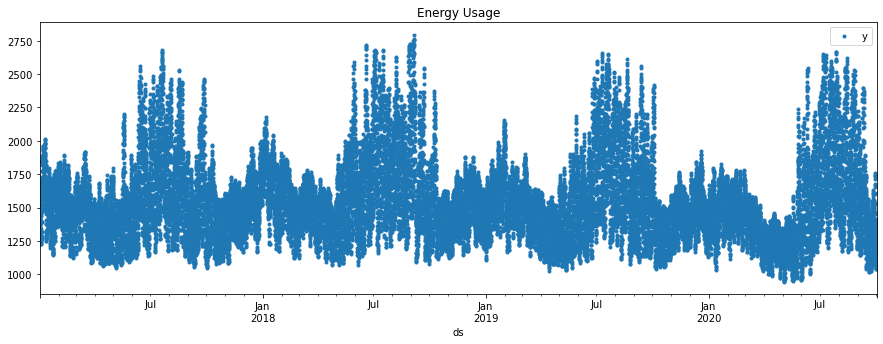

In [8]:
# let's have a look

df.plot(x="ds", y="y", style='.', figsize=(15,5), title='Energy Usage')
pyplot.show()

Now we need to set up our Prophet object. There are a number of parameters we can feed it, but if we don't include any, it will do its best to choose appropriate ones.

We can also call `fit` on our dataframe, to fit the model to our dataset. This is where our column names, locations, and date formats all have to be correct. 

In [9]:
m = Prophet()
m.fit(df) # this takes a few seconds
print("done")

done


Now, we can have Prophet make a prediction, using the `predict` method. It creates a new dataframe with a prediction for each row in the dataframe we feed it (`yhat`), as well as uncertainty intervals (`yhat_lower` to `yhat_upper`). 

In [8]:
# OK, now let's get 10/2 - 11/8
actuals_df = pd.read_csv('DUQ_hourly_oct_nov_2020.csv', parse_dates=[['datetime_date','datetime_time']])

actuals_df = actuals_df.rename(columns={"datetime_date_datetime_time": "ds", "mw": "y"})

actuals_df.head()

,ds,y
0,2020-10-02 04:00:00,1083.933
1,2020-10-02 05:00:00,1047.591
2,2020-10-02 06:00:00,1034.325
3,2020-10-02 07:00:00,1034.023
4,2020-10-02 08:00:00,1056.405


In [9]:
fcst = m.predict(df=actuals_df)
fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-10-02 04:00:00,1463.471109,1055.822056,1500.944273,1463.471109,1463.471109,-195.091570,-195.091570,-195.091570,-162.870852,...,43.213203,43.213203,43.213203,-75.433921,-75.433921,-75.433921,0.0,0.0,0.0,1268.379539
1,2020-10-02 05:00:00,1463.465167,963.800299,1425.948549,1463.465167,1463.465167,-259.966708,-259.966708,-259.966708,-226.818809,...,42.664021,42.664021,42.664021,-75.811920,-75.811920,-75.811920,0.0,0.0,0.0,1203.498459
2,2020-10-02 06:00:00,1463.459225,929.810931,1376.461005,1463.459225,1463.459225,-301.324770,-301.324770,-301.324770,-267.185959,...,42.051071,42.051071,42.051071,-76.189882,-76.189882,-76.189882,0.0,0.0,0.0,1162.134456
3,2020-10-02 07:00:00,1463.453283,910.584969,1368.226124,1463.453283,1463.453283,-318.423291,-318.423291,-318.423291,-283.215861,...,41.360375,41.360375,41.360375,-76.567804,-76.567804,-76.567804,0.0,0.0,0.0,1145.029992
4,2020-10-02 08:00:00,1463.447342,918.334422,1382.936383,1463.447342,1463.447342,-309.582832,-309.582832,-309.582832,-273.214470,...,40.577320,40.577320,40.577320,-76.945682,-76.945682,-76.945682,0.0,0.0,0.0,1153.864509


In [10]:
fcst.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
836,2020-11-06 00:00:00,1458.503687,1281.835070,1747.974542,1455.191767,1462.873093,56.569113,56.569113,56.569113,148.702356,...,45.020741,45.020741,45.020741,-137.153984,-137.153984,-137.153984,0.0,0.0,0.0,1515.072800
837,2020-11-06 01:00:00,1458.497745,1225.580833,1672.857157,1455.179935,1462.901956,0.827813,0.827813,0.827813,93.269555,...,44.605020,44.605020,44.605020,-137.046762,-137.046762,-137.046762,0.0,0.0,0.0,1459.325558
838,2020-11-06 02:00:00,1458.491803,1138.858673,1592.747739,1455.168103,1462.930820,-80.763794,-80.763794,-80.763794,12.003983,...,44.172019,44.172019,44.172019,-136.939796,-136.939796,-136.939796,0.0,0.0,0.0,1377.728009
839,2020-11-06 03:00:00,1458.485861,1073.359235,1516.531303,1455.156271,1462.959683,-172.473407,-172.473407,-172.473407,-79.352117,...,43.711794,43.711794,43.711794,-136.833085,-136.833085,-136.833085,0.0,0.0,0.0,1286.012454
840,2020-11-06 04:00:00,1458.479919,984.517626,1426.145275,1455.139125,1462.988546,-256.384277,-256.384277,-256.384277,-162.870852,...,43.213203,43.213203,43.213203,-136.726629,-136.726629,-136.726629,0.0,0.0,0.0,1202.095642


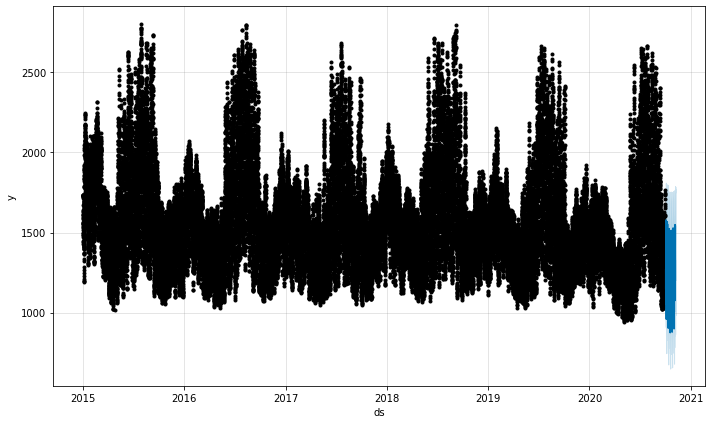

In [11]:
# let's examine our forecast
fig1 = m.plot(fcst)

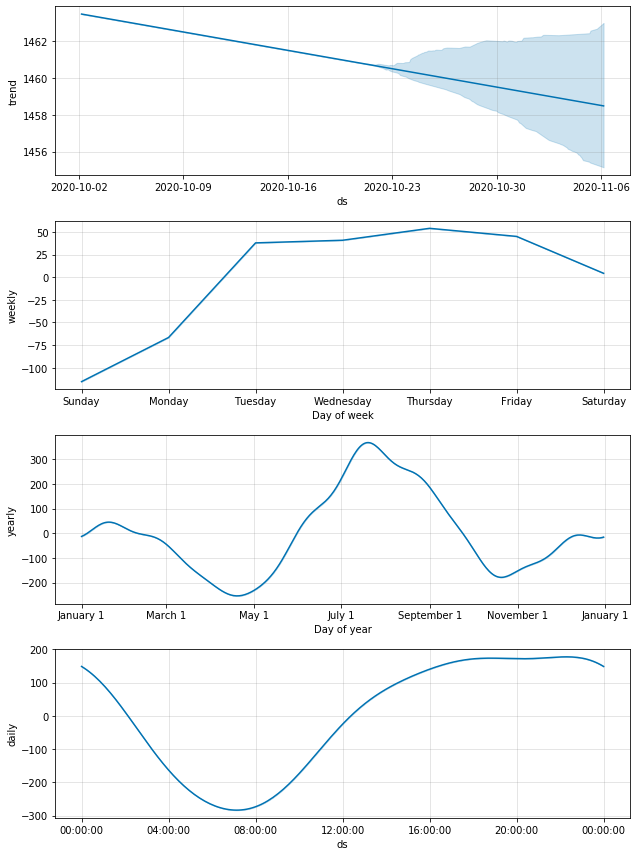

In [12]:
# and we can look at the components of the forecast
fig1 = m.plot_components(fcst)

OK, let's plot our forecast (green) versus the actual values (black) 

NameError: name 'df' is not defined

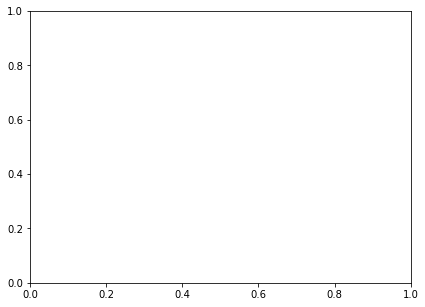

In [2]:
fig1 = pyplot.figure()
fig1.set_figheight(5)
fig1.set_figwidth(15)

ax0 = fig1.add_subplot(121)
ax0.plot_date(x=df["ds"], y=df["y"], fmt="k-")
ax0.plot_date(x=fcst["ds"], y=fcst["yhat"], fmt="g-")
ax0.plot_date(x=actuals_df["ds"], y=actuals_df["y"], fmt="k-")
pyplot.ylim(0,3000)
ax0.xaxis.set_tick_params(rotation=30, labelsize=10)

ax1 = fig1.add_subplot(122)
ax1.plot_date(x=fcst["ds"], y=fcst["yhat"], fmt="g-")
ax1.plot_date(x=actuals_df["ds"], y=actuals_df["y"], fmt="k-")
pyplot.ylim(0,3000)
ax1.xaxis.set_tick_params(rotation=30, labelsize=10)

pyplot.show()


That looks? Pretty good? But perhaps we should measure.

In [14]:
MSE = mean_squared_error(y_true=actuals_df['y'], y_pred=fcst['yhat'])
print(MSE)

10937.445861570017


In [15]:
MAE = mean_absolute_error(y_true=actuals_df['y'], y_pred=fcst['yhat'])
print(MAE)

85.74619197917299


Let's see if we do any better after adding holidays.

In [16]:
cal = calendar()
train_holidays = cal.holidays(start=df["ds"][0], end=df["ds"][len(df["ds"]) - 1])
test_holidays = cal.holidays(start=actuals_df["ds"][0], end=actuals_df["ds"][len(actuals_df["ds"]) - 1])

In [17]:
# make a df of holidays (ds + column reading "USFederalHoliday")
# code adapted from https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet

# set each date in df to True or False for if it's a holiday
df["is_holiday"] = df.ds.isin([d.date() for d in cal.holidays()])
actuals_df["is_holiday"] = actuals_df.ds.isin([d.date() for d in cal.holidays()])

# get just the rows that are holidays, and stick them in a new df
# (need holidays in both training AND test dfs)
holiday_df = df.loc[df["is_holiday"]]
hol_df2 = actuals_df.loc[actuals_df["is_holiday"]]

# glue those two dfs together
holiday_df = holiday_df.append(hol_df2, ignore_index = True)

# we need each holiday labeled "USFederalHoliday," so we make a column
holiday_df.insert(3, "holiday", "USFederalHoliday")

# then we cut out the columns we no longer need
holiday_df = holiday_df.drop(["y", "is_holiday"], axis=1)
df = df.drop(["is_holiday"], axis = 1)
actuals_df = actuals_df.drop(["is_holiday"], axis = 1)

# make our ds back into a datetime
holiday_df["ds"] = pd.to_datetime(holiday_df["ds"])
holiday_df.head()

,ds,holiday
0,2015-01-19,USFederalHoliday
1,2015-02-16,USFederalHoliday
2,2015-05-25,USFederalHoliday
3,2015-07-03,USFederalHoliday
4,2015-09-07,USFederalHoliday


C:\Users\csheldon-hess\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


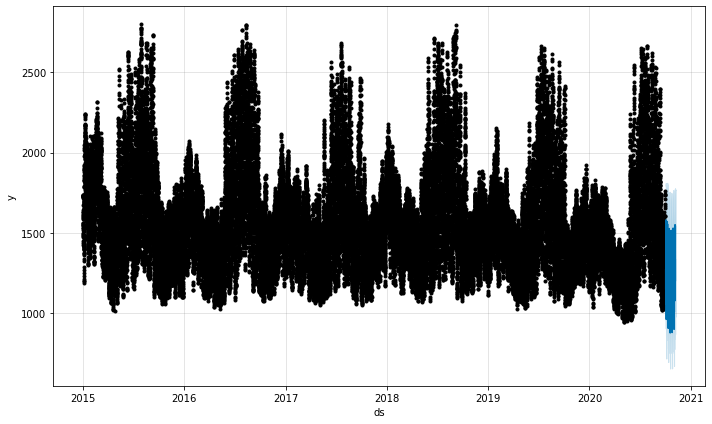

In [18]:
mh = Prophet(holidays=holiday_df)
mh.fit(df) # this takes a few seconds
fcst_h = mh.predict(df=actuals_df)
# let's examine our forecast
fig2 = mh.plot(fcst_h)

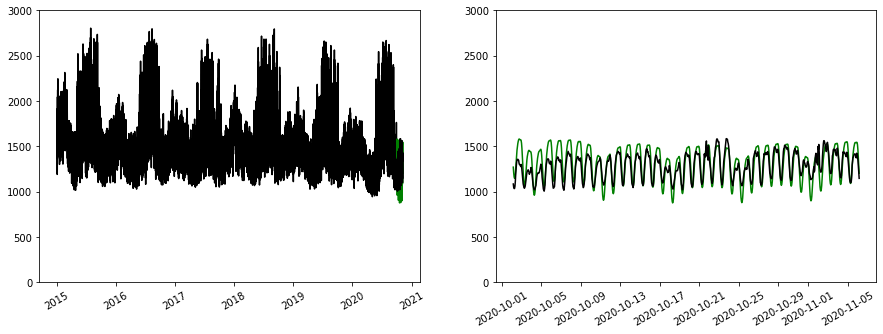

In [19]:
fig2 = pyplot.figure()
fig2.set_figheight(5)
fig2.set_figwidth(15)

ax0 = fig2.add_subplot(121)
ax0.plot_date(x=df["ds"], y=df["y"], fmt="k-")
ax0.plot_date(x=fcst_h["ds"], y=fcst_h["yhat"], fmt="g-")
ax0.plot_date(x=actuals_df["ds"], y=actuals_df["y"], fmt="k-")
pyplot.ylim(0,3000)
ax0.xaxis.set_tick_params(rotation=30, labelsize=10)

ax1 = fig2.add_subplot(122)
ax1.plot_date(x=fcst_h["ds"], y=fcst_h["yhat"], fmt="g-")
ax1.plot_date(x=actuals_df["ds"], y=actuals_df["y"], fmt="k-")
pyplot.ylim(0,3000)
ax1.xaxis.set_tick_params(rotation=30, labelsize=10)

pyplot.show()

In [20]:
print("MSE, no holidays:", MSE)
print("MAE, no holidays:", MAE)
MSE_h = mean_squared_error(y_true=actuals_df['y'], y_pred=fcst_h['yhat'])
MAE_h = mean_absolute_error(y_true=actuals_df['y'], y_pred=fcst_h['yhat'])
print("MSE, holidays:", MSE_h)
print("MAE, holidays:", MAE_h)

MSE, no holidays: 10937.445861570017
MAE, no holidays: 85.74619197917299
MSE, holidays: 11081.396805827188
MAE, holidays: 86.32283874609016


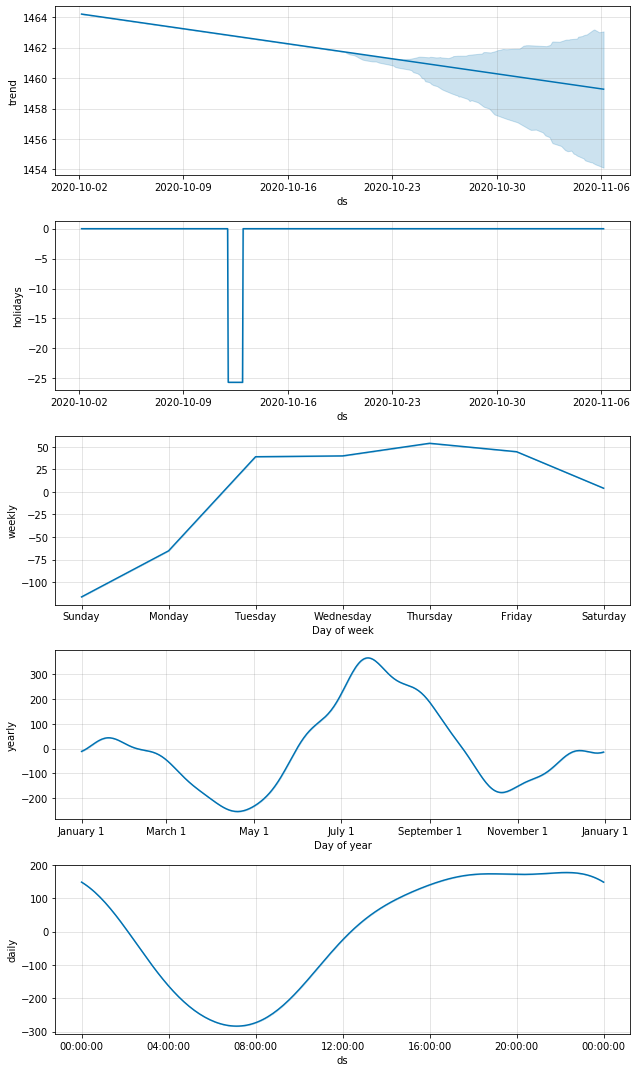

In [21]:
fig2 = mh.plot_components(fcst_h)